# 1. Introduction

## 1.1 Connecting to the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 Importing the libraries

In [2]:
import os
import numpy as np
import gc #garbage collector
import random

from tqdm.notebook import tqdm #progress bar

from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall, SensitivityAtSpecificity, SpecificityAtSensitivity, MeanIoU
from tensorflow.keras import Model, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import plot_model

## 1.3 Defining global variables

In [3]:
IM_HEIGHT = 256
IM_WIDTH = 256

# 2. Modeling

## 2.1 defining the model (U-net)

In [4]:
## 2D two Convolution layer block
def Conv2D_block(input_tensor, n_filters, kernel_size=3, batchnorm=True): #Function to add 2 convolutional layers
    #Convolution layer - 1
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(input_tensor)
    #batchnormalization
    if batchnorm:
        x = BatchNormalization()(x)
    #Activation
    x = Activation('relu')(x)
        
    #Convolution layer - 2
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(x)
    #batchnormalization
    if batchnorm:
        x = BatchNormalization()(x)
    #Activation
    x = Activation('relu')(x)
        
    return x

In [5]:
#Unet Architecture
def unet(input_image, n_filters=16, kernel_size=3, dropout=0.1, batchnorm=True):
    #Encoder Path || Contractor Path
    c1 = Conv2D_block(input_image, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = Conv2D_block(p1, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = Conv2D_block(p2, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = Conv2D_block(p3, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = Conv2D_block(p4, n_filters * 16, kernel_size = kernel_size, batchnorm = batchnorm)

    
    #Decoder Path  || Expansion Path
    u6 = Conv2DTranspose(n_filters * 8, (kernel_size, kernel_size), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = Conv2D_block(u6, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (kernel_size, kernel_size), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = Conv2D_block(u7, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (kernel_size, kernel_size), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = Conv2D_block(u8, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
   
    u9 = Conv2DTranspose(n_filters, (kernel_size, kernel_size), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = Conv2D_block(u9, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)
   
    #final 1*1 Convolutional layer
    output = Conv2D(1, (1,1), activation='sigmoid')(c9)
    model = Model(inputs=[input_image], outputs=[output])
    return model

In [6]:
def dice_coef(y_true, y_pred, smooth=1):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  
def iou(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)

  intersection = K.sum(y_true_f * y_pred_f)
  union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

  return intersection/union

# 3 Results

In [7]:
#Instantiate Keras tensor
input_img = Input((IM_HEIGHT, IM_WIDTH, 3), name='img')
metrics=[Accuracy(), Precision(), Recall(), iou, dice_coef, SensitivityAtSpecificity(0.5), SpecificityAtSensitivity(0.5)]

#initialize params
n_filters = 16
kernel_size = 5
dropout = 0.05
batch_size = 32
epochs = 50
optimizer = Adam()

#Loading converted images into arrays

X = np.load("/content/drive/MyDrive/skin_cancer/assets/numpy_images/x_train.npy")
y = np.load("/content/drive/MyDrive/skin_cancer/assets/numpy_images/y_train.npy")

X_valid = np.load("/content/drive/MyDrive/skin_cancer/assets/numpy_images/x_valid.npy")
y_valid = np.load("/content/drive/MyDrive/skin_cancer/assets/numpy_images/y_valid.npy")

In [8]:
#Instantiate Keras tensor
input_img = Input((IM_HEIGHT, IM_WIDTH, 3), name='img')
metrics=[Accuracy(), Precision(), Recall(), iou, dice_coef, SensitivityAtSpecificity(0.5), SpecificityAtSensitivity(0.5)]

# create model
model = unet(input_img, n_filters=n_filters, kernel_size=kernel_size, dropout=dropout, batchnorm=True)
# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
# Carrega os pesos
model.load_weights('/content/drive/MyDrive/skin_cancer/models/unet/assets/unet_16_5_32_50.h5')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  1216        ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

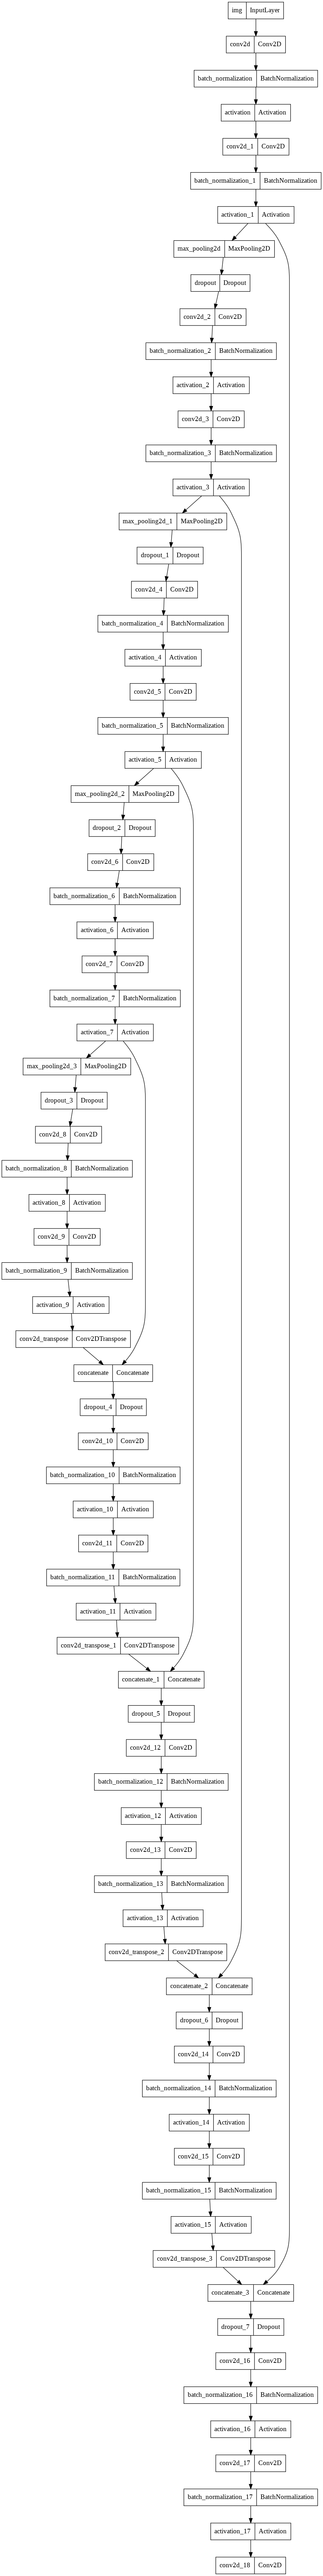

In [ ]:
plot_model(model, "my_first_model.png")

In [9]:
model.evaluate(X_valid, y_valid, verbose=1)

4/4 [==============================] - 48s 10s/step - loss: 0.2160 - accuracy: 0.0000e+00 - precision_1: 0.9191 - recall_1: 0.8476 - iou: 0.5756 - dice_coef: 0.7303 - sensitivity_at_specificity_1: 0.9980 - specificity_at_sensitivity_1: 0.9996


[0.21603965759277344,
 0.0,
 0.9190942645072937,
 0.8476473689079285,
 0.575607419013977,
 0.7302611470222473,
 0.9980013370513916,
 0.9996438026428223]

In [10]:
preds_val = model.predict(X_valid, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

4/4 [==============================] - 44s 10s/step


In [18]:
def plot_sample_results(X, y, preds, binary_preds, has_mask):
    ix = random.randint(0, len(X))
    ix = 84
    
    fig, ax = plt.subplots(1, 4, figsize=(20,10))
    
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[0].set_title('real mask')
    
    ax[1].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[1].set_title('cancer Predicted')
    
    ax[2].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[2].set_title('cancer Predicted Binary')

    ax[3].imshow(X[ix])
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[3].contour(binary_preds[ix].squeeze(), colors='m', levels=[0.5])
    ax[3].set_title('cancer')

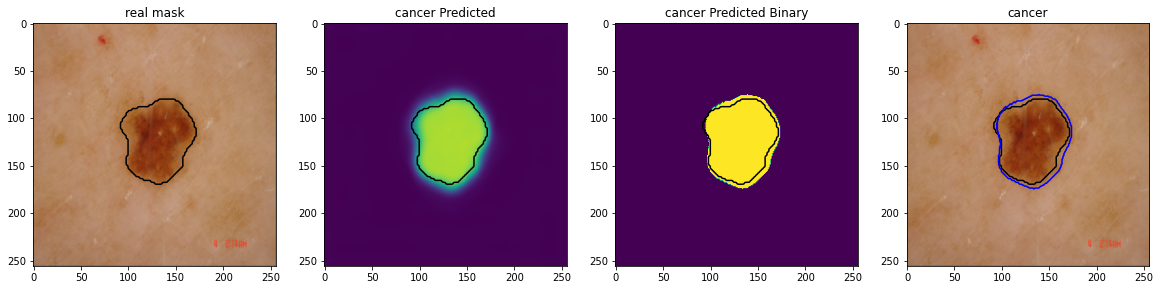

In [ ]:
## Predictions on Test Set
plot_sample_results(X=X_valid, y=y_valid, preds=preds_val, binary_preds=preds_val_t, has_mask=True)

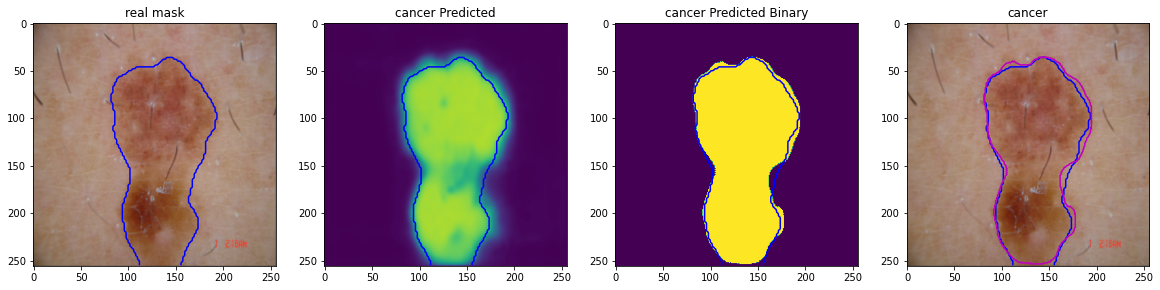

In [19]:
## Predictions on Test Set
plot_sample_results(X=X_valid, y=y_valid, preds=preds_val, binary_preds=preds_val_t, has_mask=True)